In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import levene

# 5. Статистический анализ

Компания по продаже кухонных гарнитуров решила добавить 3D визуализацию своей продукции с целью увеличения конверсии. Нашей задачей будет узнать эффективность нового функционала и провести A/B тестирование с предоставленными компанией данными

In [3]:
# Загрузка данных
df = pd.read_csv('data/ab_data.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
df['timestamp'] = df['timestamp'].astype("datetime64[ns]").dt.day

In [17]:

df_control = df[(df.group == 'control')].converted.sum()
df_treatment = df[(df.group == 'treatment')].converted.sum()

In [21]:
df.groupby(by='group')[['group']].value_counts()


group
control      145188
treatment    145294
Name: count, dtype: int64

In [ ]:
df.groupby(by='user_id')[['converted']].value_counts()

In [ ]:
#Просмотр информации о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
# Проверка на дубликаты
print(f'В датасете {len(df) - len(df.drop_duplicates())} дубликатов строк')

В датасете 0 дубликатов строк


In [ ]:
df 

In [ ]:
# Проверка на пропущенные значения
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
#Количество уникальных пользователей
df.user_id.nunique()

290584

Количество user_id (290584) меньше количества строк в наборе данных (294478). Следовательно часть пользователнй повторяется

In [4]:
#выведем строки с одинаковыми user_id
duplicateDFRow = df[df.duplicated(subset = 'user_id', keep = False)].sort_values(by = 'user_id')
duplicateDFRow 

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2017-01-08 19:40:51.169351,control,new_page,0
186960,945797,2017-01-13 17:23:21.750962,control,old_page,0
40370,945797,2017-01-11 03:04:49.433736,control,new_page,1
165143,945971,2017-01-16 10:09:18.383183,control,old_page,0


In [6]:
temp_ = duplicateDFRow.groupby(by='user_id')[['landing_page']].value_counts().unstack()
temp_

landing_page,new_page,old_page
user_id,,
630052,1.0,1.0
630126,1.0,1.0
630137,1.0,1.0
630320,NaN,2.0
630471,1.0,1.0
...,...,...
945627,2.0,NaN
945645,1.0,1.0
945703,1.0,1.0


In [7]:
temp_drop = temp_[(temp_.new_page.isna() != True) & (temp_.old_page.isna() != True)]
temp_drop

landing_page,new_page,old_page
user_id,,
630052,1.0,1.0
630126,1.0,1.0
630137,1.0,1.0
630471,1.0,1.0
630780,1.0,1.0
...,...,...
945510,1.0,1.0
945645,1.0,1.0
945703,1.0,1.0


In [9]:
#удаляю строки с ошибозными данными
df = df.loc[~df['user_id'].isin(temp_drop.index)]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [10]:
duplicateDFRow = df[df.duplicated(subset = 'user_id', keep = False)].sort_values(by = 'user_id')
duplicateDFRow 

,user_id,timestamp,group,landing_page,converted
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
73599,630805,2017-01-12 20:45:39.012189,treatment,old_page,0
39852,630805,2017-01-22 12:01:15.144329,control,old_page,0
213377,630871,2017-01-08 14:00:05.181612,control,old_page,0
...,...,...,...,...,...
32034,945369,2017-01-24 08:20:11.861088,treatment,old_page,0
275158,945387,2017-01-20 02:12:45.553852,control,new_page,0
183169,945387,2017-01-03 01:12:35.747597,treatment,new_page,0
49419,945627,2017-01-06 00:03:20.474879,control,new_page,1


In [14]:
temp_ = duplicateDFRow.groupby(by='user_id')[['group']].value_counts().unstack().dropna()
temp_

group,control,treatment
user_id,,
630320,1.0,1.0
630805,1.0,1.0
630871,1.0,1.0
630887,1.0,1.0
631008,1.0,1.0
...,...,...
945272,1.0,1.0
945308,1.0,1.0
945369,1.0,1.0


In [15]:
#удаляю строки с ошибозными данными
df = df.loc[~df['user_id'].isin(temp_drop.index)]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [18]:
df_control = df[(df.group == 'control')].converted.sum()
df_treatment = df[(df.group == 'treatment')].converted.sum()

In [19]:
df_treatment

17249

In [20]:
df_control

17456

In [10]:
duplicateDFRow.groupby(by='landing_page')[['converted']].sum()

,converted
landing_page,
new_page,473
old_page,519


In [11]:
for i in  duplicateDFRow.user_id.unique():
    print (i)

630052
630126
630137
630320
630471
630780
630785
630805
630871
630887
631008
631132
631156
631316
631337
631365
631459
631470
631604
631838
631917
631948
632069
632115
632187
632302
632464
632522
632592
632642
632690
632717
632794
633126
633243
633344
633443
633692
633793
633832
633897
633949
634005
634027
634090
634098
634203
634230
634290
634552
634574
634598
634605
634611
634881
634888
634965
634971
634992
635003
635048
635156
635269
635278
635479
635606
635737
635787
635809
635984
636027
636205
636279
636280
636298
636332
636375
636424
636555
636565
636583
636626
636656
636715
636752
636868
636909
637018
637106
637214
637293
637310
637315
637428
637561
637639
637805
637900
637930
638022
638068
638263
638346
638376
638460
638525
638565
638584
638745
638766
639059
639090
639119
639211
639310
639366
639386
639407
639463
639533
639555
639635
639817
639841
639843
639951
640064
640111
640235
640253
640320
640587
640782
640826
640854
640909
640989
641299
641393
641507
641570
641751
641906

In [9]:
df_drop = duplicateDFRow[(duplicateDFRow.group == 'control' & duplicateDFRow.group == 'treatment')]

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

In [7]:
duplicateDFRow.groupby(by='user_id')[['landing_page']].value_counts()

user_id  landing_page
630052   new_page        1
         old_page        1
630126   old_page        1
         new_page        1
630137   old_page        1
                        ..
945703   old_page        1
945797   new_page        1
         old_page        1
945971   new_page        1
         old_page        1
Name: count, Length: 5892, dtype: int64

In [ ]:
duplicateDFRow.groupby(by='user_id')[['group']].value_counts()

Из вывода строк выше видно что, один посещает и cтарую страницу и новую страницу, чего быть не должно

In [ ]:
#удалю этих' пользователей
df_drop_user = df.drop_duplicates(subset = 'user_id', keep = False, ignore_index = True)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
286685,751197,2017-01-03 22:28:38.630509,control,old_page,0
286686,945152,2017-01-12 00:51:57.078372,control,old_page,0
286687,734608,2017-01-22 11:45:03.439544,control,old_page,0
286688,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [ ]:
#Посмотрю на группы
df_drop_user.groupby(by='group')[['landing_page']].value_counts()

group      landing_page
control    old_page        143293
treatment  new_page        143397
Name: count, dtype: int64

Теперь с данными все в порядке

In [ ]:
df_drop_user.groupby(by='group')[['converted']].value_counts()

group      converted
control    0            126073
           1             17220
treatment  0            126372
           1             17025
Name: count, dtype: int64

In [ ]:
err = df.shape[0]-df_drop_user.shape[0]
proc_err = round(err / df.shape[0] * 100, 1)
print(f'Я удалили {err} строк ошибочных данных, что составляет {proc_err} % исходных данных') 

Я удалили 7788 строк ошибочных данных, что составляет 2.6 % исходных данных


In [ ]:
#Создам датафремы для каждой груммы
df_control = df_drop_user[(df_drop_user.group == 'control')]
df_treatment = df_drop_user[(df_drop_user.group == 'treatment')]

In [ ]:
conv_treatment = df_treatment.converted.sum() / df_treatment.shape[0] * 100
conv_treatment

11.872633318688676

In [ ]:
conv_control = df_control.converted.sum() / df_control.shape[0] * 100
conv_control

12.017335110577628

In [ ]:
# T-тест для сравнения средних значений конверсий в тестовых группах

# Функция для для t-теста и вывода стаитистической значимости
def result_ttest (group_1, group_2):
    _, p_value = ttest_ind(group_1, group_2)
    negative = f' P-значение = {p_value}. \n Статистически значимых различий между группами не найдено'
    positive = f' P-значение = {p_value}. \n Обнаружены статистически значимые различия между группами'
    if p_value > alpha:
        return negative
    else:
        return positive



#Тест Левена для определения равенства дисперсий.
# Функция для теста Levena и вывода стаитистической значимости
def result_levene (group_1, group_2):
    _, p_value = levene(group_1, group_2, center='mean')
    negative = f' P-значение = {p_value}. \n Статистически значимых различий между группами не найдено'
    positive = f' P-значение = {p_value}. \n Обнаружены статистически значимые различия между группами'
    if p_value > alpha:
        return negative
    else:
        return positive


АА

In [ ]:
alpha = 0.05
# Разделим наши данные на две группы
df_p = df.sample(frac = 1)
df_AA1 = df_p.iloc[:(round(df.shape[0]/2))]
df_AA2 = df_p.iloc[(round(df.shape[0]/2)):]

# Проверим размеры групп
print(df_AA1.shape)
print(df_AA2.shape)

# Проведем t-тест для проверки различий между группами
conversion_by_AA1 = df_AA1.groupby(['group'])['converted'].sum()
conversion_by_AA2 = df_AA2.groupby(['group'])['converted'].sum()

print(f'Для значений конверсии групп AA1 и AA2 {result_ttest(conversion_by_AA1, conversion_by_AA2)}')



(147239, 5)
(147239, 5)
Для значений конверсии групп AA1 и AA2  P-значение = 0.9861871367211152. 
 Статистически значимых различий между группами не найдено


Набор данных представляет собой результаты A/B тестирования мобильной игры Cookie cats.

После установки игры пользователя случайным образом распределили в контрольную группу gate_30 или экспериментальную gate_40.

sum_gamerounds — количество сыгранных раундов в первые 14 дней.

retention_1 — пользователь вернулся через 1 день после установки.

retention_7 — пользователь вернулся через 7 дней после установки


In [ ]:
print(f'Для значений конверсии групп AA1 и AA2 {result_ttest(conversion_by_AA1, conversion_by_AA2)}')

In [ ]:
# Загрузка данных
df = pd.read_csv('data/Games_AB.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [ ]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [ ]:
# Проверка на дубликаты
print(f'В датасете {len(df) - len(df.drop_duplicates())} дубликатов строк')

В датасете 0 дубликатов строк


In [ ]:
# Проверка на пропущенные значения
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [ ]:
df.userid.nunique()

90189

In [ ]:
#Предобработка данных
df.retention_1 = df.retention_1.astype(int) #поменять тип данных в столбце *converted* на числовой
df.retention_7 = df.retention_7.astype(int) #поменять тип данных в столбце *converted* на числовой

In [ ]:
df_gate_30 = df[(df.version == 'gate_30')]
df_gate_40 = df[(df.version == 'gate_40')]

Интернет-магазин решил внести изменения в свой сайт и добавил в него больше интерактивности и мелких деталей. Теперь компании необходимо провести A/B тестирование и узнать, изменился ли доход или нет

In [ ]:
# Загрузка данных
df = pd.read_csv('data/AB_Test_Results.csv')
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [ ]:
df_control = df[(df.VARIANT_NAME == 'control')]
df_variant = df[(df.VARIANT_NAME == 'variant')]

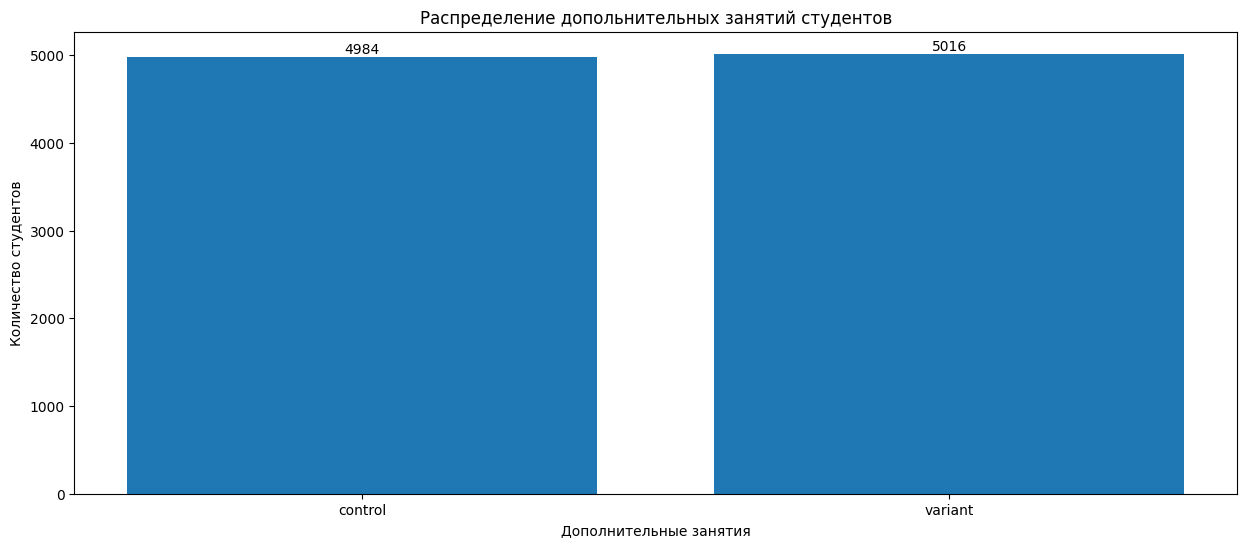

In [ ]:
# Визуализация распределения допольнительных занятий студентов до обработки пропусков
df_ = df.groupby(by ='VARIANT_NAME')[['VARIANT_NAME']].value_counts()
fig, ax =  plt.subplots(1, figsize = [15, 6])
ax.bar(x = df_.index, height = df_.values) 
ax.set_title('Распределение допольнительных занятий студентов')
ax.set_ylabel('Количество студентов')
ax.set_xlabel('Дополнительные занятия')
ax.bar_label (ax.containers [ 0 ])
plt.show();

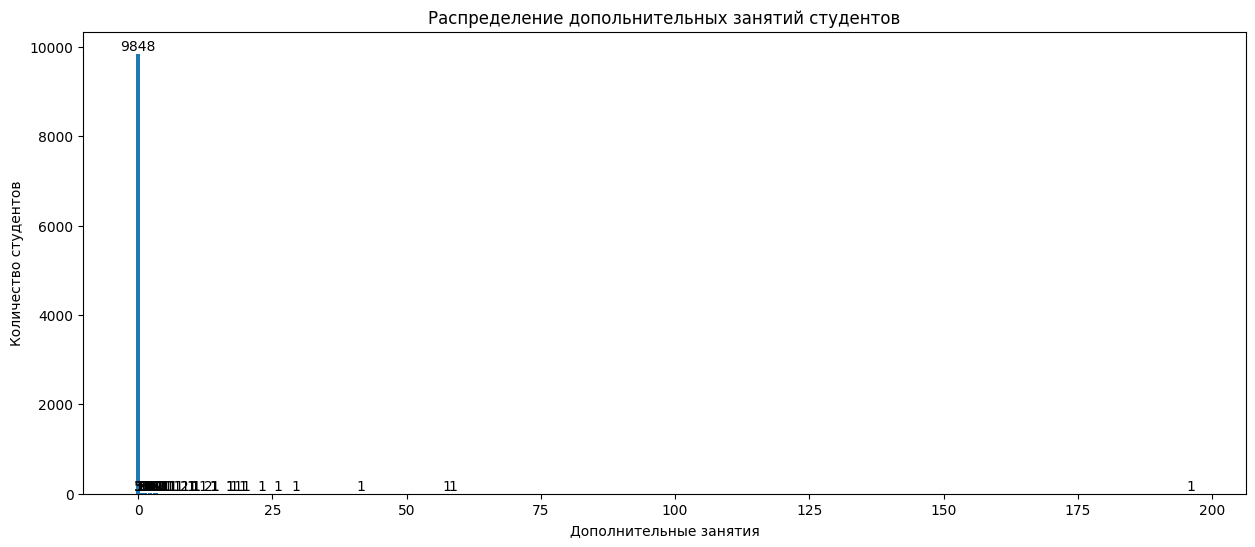

In [ ]:
# Визуализация распределения допольнительных занятий студентов до обработки пропусков
df_ = df.groupby(by ='REVENUE')[['REVENUE']].value_counts()
fig, ax =  plt.subplots(1, figsize = [15, 6])
ax.bar(x = df_.index, height = df_.values) 
ax.set_title('Распределение допольнительных занятий студентов')
ax.set_ylabel('Количество студентов')
ax.set_xlabel('Дополнительные занятия')
ax.bar_label (ax.containers [ 0 ])
plt.show();

In [ ]:
# Сравнение количества просмотров маркетинговых кампаний
view_ads = sum(df_ads.total_ads)
view_psa = sum(df_psa.total_ads)
print('Количестов просмотров рекламы в ГРУППЕ ADS - ', view_ads)
print('Количестов просмотров рекламы в ГРУППЕ РSA - ', view_psa)

# Изучение процента пользователей, которые конвертировались после просмотра объявления
proc_ads = cr_ads * 100
proc_psa = cr_psa * 100
print('Процент пользователей, которые конвертировались после просмотра объявления в ГРУППЕ ADS - ', proc_ads)
print('Процент пользователей, которые конвертировались после просмотра объявления в ГРУППЕ PSA - ', proc_psa)

# Визуализация процента пользователей, которые конвертировались после просмотра объявлений и 
# количества просмотров маркетинговых кампаний
fig, ax =  plt.subplots(1, 2, figsize = [15, 6]) 
ax[0].bar(x = ['ГРУППA ADS','ГРУППA PSA'], height = [view_ads,view_psa])
ax[1].bar(x = ['ГРУППA ADS','ГРУППA PSA'], height = [proc_ads,proc_psa])
ax[0].set_title('Количестов просмотров рекламы')
ax[1].set_title('Процент пользователей, которые \n конвертировались после просмотра объявления')
ax[0].set_ylabel('Количестов просмотров (1e7)')
ax[1].set_ylabel('Процент пользователей')
ax[0].set_xlabel('Группа')
ax[1].set_xlabel('Группа')
plt.show();

In [ ]:
# Определение нормальности распределения конверсий в тестовых группах (Shapiro-Wilk тест)
alpha = 0.05 #Уровень значимости
# Функция для для Shapiro-Wilk-теста 
def result_shapiro (group_1):
    _, p_value = shapiro(group_1)
    negative = f' P-значение = {p_value}. \
        \n Не обнаружены статистически значимые различия между распрелением в группе и нормальным распределением \n'
    positive = f' P-значение = {p_value}. \
        \n Обнаружены статистически значимые различия между распрелением в группе и нормальным распределением \n'
    if p_value > alpha:
        return negative
    else:
        return positive

print(f'Для группs АDS  {result_shapiro(conversion_by_ads)}')
print(f'Для группs PSA  {result_shapiro(conversion_by_psa)}')


# T-тест для сравнения средних значений конверсий в тестовых группах

# Функция для для t-теста и вывода стаитистической значимости
def result_ttest (group_1, group_2):
    _, p_value = ttest_ind(group_1, group_2)
    negative = f' P-значение = {p_value}. \n Статистически значимых различий между группами не найдено'
    positive = f' P-значение = {p_value}. \n Обнаружены статистически значимые различия между группами'
    if p_value > alpha:
        return negative
    else:
        return positive

print(f'Для средних значений конверсии групп АDS и PSA {result_ttest(mean_conversion_by_ads, mean_conversion_by_psa)}')

#Тест Левена для определения равенства дисперсий.
# Функция для теста Levena и вывода стаитистической значимости
def result_levene (group_1, group_2):
    _, p_value = levene(group_1, group_2, center='mean')
    negative = f' P-значение = {p_value}. \n Статистически значимых различий между группами не найдено'
    positive = f' P-значение = {p_value}. \n Обнаружены статистически значимые различия между группами'
    if p_value > alpha:
        return negative
    else:
        return positive
print(f'\n Для значений дисперсий конверсии групп АDS и PSA {result_ttest(conversion_by_ads, conversion_by_psa)}')



Для группs АDS   P-значение = 7.96834358753664e-41.         
 Обнаружены статистически значимые различия между распрелением в группе и нормальным распределением 

Для группs PSA   P-значение = 5.934938222445106e-23.         
 Обнаружены статистически значимые различия между распрелением в группе и нормальным распределением 

Для средних значений конверсии групп АDS и PSA  P-значение = 0.0037180429154445357. 
 Обнаружены статистически значимые различия между группами

 Для значений дисперсий конверсии групп АDS и PSA  P-значение = 1.2383669015030934e-17. 
 Обнаружены статистически значимые различия между группами
